<a href="https://colab.research.google.com/github/AhmedWael2000/fasttext/blob/main/Fasttext_using_gensim_library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install reportlab fasttext

In [ ]:
! kaggle datasets download -d yelp-dataset/yelp-dataset
! unzip yelp-dataset.zip

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open yelp-dataset.zip, yelp-dataset.zip.zip or yelp-dataset.zip.ZIP.


In [ ]:
%%capture
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [ ]:
import fasttext
from huggingface_hub import hf_hub_download
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from matplotlib import pyplot as plt
from gensim.models import fasttext as fst
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from gensim.models.fasttext import FastText # build and train Fast Text model
from gensim.models import Word2Vec # to Save and Load Word2Vec models
from gensim.models.fasttext import load_facebook_model
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data_path = '/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json'


data = pd.read_json(
    data_path,
    lines = True
)

print(data.columns)
data.shape

Index(['user_id', 'business_id', 'text', 'date', 'compliment_count'], dtype='object')


(908915, 5)

In [ ]:
docs = data['text'][:200000].values

print("\nSamples of Sentences\n [{}]".format(docs[0:10]))


Samples of Sentences
 [['Avengers time with the ladies.'
 'They have lots of good deserts and tasty cuban sandwiches'
 "It's open even when you think it isn't" 'Very decent fried chicken'
 'Appetizers.. platter special for lunch'
 'Chili Cup + Single Cheeseburger with onion, pickle, and relish + Vanilla Coca-Cola...so far.'
 "Saturday, Dec 7th 2013, ride Patco's Silver Sleigh w/ Santa & his elves on a decorated train into Center City. Trains leave from Lindenwold at 10am, 11:15am, & 12:30pm, and make all stops. Great for kids!"
 'This is probably the best place in the cool Springs area to watch a game and eat'
 'Tacos'
 'Starbucks substitute in boring downtown Tampa. Ugh. Never again!']]


In [ ]:
# en_stop = set(stopwords.words('english'))
def process_text(document):
  document = re.sub(r'\s+', ' ', document, flags=re.I) # Remove extra white space from text
  document = re.sub(r'\W', ' ', str(document)) # Remove all the special characters from text
  document = re.sub(r'\s+[A-z]\s+', ' ', document) # Remove all single characters from text
  document = document.lower() # Converting to Lowercase
  # Word tokenization
  tokens = document.split()
  lemma_txt = [lemmatizer.lemmatize(word) for word in tokens if word not in en_stop]
  # Drop words
  tokens = [word for word in lemma_txt if len(word) > 3]
  # clean_txt = ' '.join(lemma_txt)
  return tokens

In [ ]:
sub_docs = docs[70:73]

for doc in sub_docs:
  processesed_doc = process_text(doc)
  print(f"OG doc:\t{doc},\nProcessed doc:\t{processesed_doc}", end="\n\n")

OG doc:	Lots of great 100 anniversary specials on now!,
Processed doc:	['great', 'anniversary', 'special']

OG doc:	College crowd dive bar scene. Friendly folks & lots of Irish eye candy ;) hahaha,
Processed doc:	['college', 'crowd', 'dive', 'scene', 'friendly', 'folk', 'irish', 'candy', 'hahaha']

OG doc:	Fish and chips are very good.,
Processed doc:	['fish', 'chip', 'good']



In [ ]:
processesed_docs = list(
    tqdm(
        map(
            process_text,
            docs),
        total=len(docs)))

100%|██████████| 200000/200000 [00:11<00:00, 16986.14it/s]


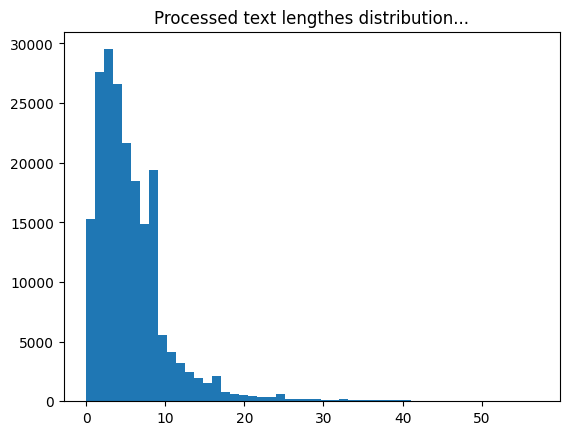

In [ ]:
plt.hist(
    list(map(len, processesed_docs)),
    bins = 50
    )
plt.title("Processed text lengthes distribution...")
plt.show()

In [ ]:
embedding_size = 300
window_size = 5
min_word = 5
down_sampling = 1e-2

In [ ]:
model = FastText(
    vector_size=embedding_size,
    window=window_size,
    min_count=min_word,
    workers = 4,
    sg=1
    )  # Adjust the parameters as needed

model.build_vocab(
    corpus_iterable=processesed_docs
)
for epoch in tqdm(range(100)):
  model.train(
      corpus_iterable=processesed_docs,
      total_examples=len(processesed_docs),
      epochs=1
      )  # Train the model


100%|██████████| 100/100 [12:22<00:00,  7.43s/it]


In [ ]:
model.save('our_fast_text_model.bin') # Save fastText gensim model


In [ ]:
# Load saved gensim fastText model
fast_Text_model = Word2Vec.load('/content/our_fast_text_model.bin')

In [ ]:

list(fast_Text_model.wv.key_to_index.keys())[:10]

['great',
 'good',
 'food',
 'place',
 'service',
 'best',
 'love',
 'time',
 'awesome',
 'like']

In [ ]:
test_words = [
    'felafel',
    'good',
    'car',
    'newspaper',
    'single',
    'total',
    'screen',
    'watch'
]

# Get Similar and Opposite Words

In [ ]:
def similar_and_opposite(model,test_words):
    similar_words = list()
    opposite_words = list()
    for word in test_words:
      similar_words.append([x for x, _ in model.wv.most_similar(word, topn=10)])
      opposite_words.append([x for x, _ in model.wv.most_similar(negative=[word], topn=10)])
    return similar_words, opposite_words


In [ ]:
similar_words, opposite_words = similar_and_opposite(model,test_words)

In [ ]:
for word, sim_list, opp_list in zip(test_words, similar_words, opposite_words):
  print(f"for word {word}:\n{'='*7}\nMost similar wordes are: \n{sim_list}\n\nMost opposite words are: \n{opp_list}",
        end=f"\n\n\n{'#'*10} {'$'*5} {'#'*10}\n\n")

for word felafel:
Most similar wordes are: 
['falafel', 'ghanoush', 'babaganoush', 'ganoush', 'pernil', 'baba', 'shwarma', 'tabbouleh', 'palermo', 'vegetable']

Most opposite words are: 
['dunkin', 'player', 'allowed', 'cleaning', 'tactic', 'raising', 'booking', 'rarity', 'pull', 'wasting']


########## $$$$$ ##########

for word good:
Most similar wordes are: 
['great', 'amazing', 'tasty', 'delicious', 'excellent', 'goood', 'gooood', 'awesome', 'decent', 'goooood']

Most opposite words are: 
['dentist', 'lane', 'block', 'performance', 'story', 'begin', 'various', 'dance', 'entire', 'extended']


########## $$$$$ ##########

for word car:
Most similar wordes are: 
['streetcar', 'sidecar', 'oscar', 'carson', 'mejor', 'omar', '5056', 'carnivaltime', 'frenchquarter', 'carl']

Most opposite words are: 
['slightly', 'regularly', 'nightly', 'rather', 'upon', 'hopefully', 'samosa', 'gotten', 'temperature', 'boring']


########## $$$$$ ##########

for word newspaper:
Most similar wordes are: 


In [ ]:
# Check word embedding for a perticular word
test_word="felafel"
print(fast_Text_model.wv[test_word])

[-5.20541370e-01  9.90191028e-02  7.81551674e-02 -2.58916896e-02
 -4.09719467e-01 -2.78078198e-01 -1.61670938e-01 -2.83257812e-01
  1.99897230e-01  1.55378789e-01  1.07840255e-01  2.40663648e-01
 -2.13077635e-01 -8.98825824e-02 -1.46702081e-01  9.23437327e-02
 -9.83811393e-02 -2.68683046e-01  1.39537558e-01  1.13004446e-01
 -6.53061390e-01  4.72824186e-01  3.45663652e-02 -3.27591121e-01
 -1.23066008e-01  4.45277244e-01  4.43608373e-01  4.54396941e-02
 -7.86847398e-02 -8.36455226e-01 -1.06406868e-01 -3.67655247e-01
 -1.06103502e-01  1.28222451e-01 -3.16613913e-01 -7.09916726e-02
 -4.53185923e-02 -1.56956896e-01 -2.76642561e-01  2.37877935e-01
 -2.91622877e-02 -1.71608180e-01  3.28522235e-01 -3.95288989e-02
 -1.66274652e-01 -8.53604451e-02 -1.25995018e-02  4.92078751e-01
  7.23189056e-01  3.96779358e-01 -1.32987767e-01 -1.27943397e-01
  1.91909567e-01  4.54687327e-01  2.47159019e-01  2.29802713e-01
  4.38970685e-01  7.10925534e-02 -1.23896338e-01 -2.53202081e-01
  3.00336722e-02 -1.95373

In [ ]:
# Check top 10 similar word for a given word by gensim fastText
print(*fast_Text_model.wv.most_similar(test_word, topn=10), sep='\n')


('falafel', 0.7094463109970093)
('ghanoush', 0.42663753032684326)
('babaganoush', 0.4087250530719757)
('ganoush', 0.39360058307647705)
('pernil', 0.3890381455421448)
('baba', 0.38619598746299744)
('shwarma', 0.3757225573062897)
('tabbouleh', 0.37245631217956543)
('palermo', 0.3709441125392914)
('vegetable', 0.3701871931552887)


In [ ]:


model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")
model = fst.load_facebook_model(model_path)
# model = fasttext.load_model(model_path)

model.bin:   0%|          | 0.00/7.24G [00:00<?, ?B/s]

In [ ]:
model.wv.most_similar(positive=["good"], topn=10)

[('bad', 0.7517590522766113),
 ('great', 0.7426096796989441),
 ('decent', 0.7299688458442688),
 ('nice', 0.7123615741729736),
 ('Good', 0.6796905994415283),
 ('excellent', 0.673703134059906),
 ('goood', 0.6695919036865234),
 ('ggod', 0.6602178812026978),
 ('semi-good', 0.6479218006134033),
 ('good.Good', 0.6417750120162964)]

In [ ]:
pre_similar_words,pre_opposite_words = similar_and_opposite(model,test_words)

In [ ]:
for word, sim_list, opp_list in zip(test_words, pre_similar_words, pre_opposite_words):
    text=f"for word {word}:\n{'='*7}\nMost similar wordes are: \n{sim_list}\n\nMost opposite words are: \n{opp_list}\n\n\n{'#'*10} {'$'*5} {'#'*10}\n\n"
    print(text)


for word felafel:
Most similar wordes are: 
['falafel', 'falafels', 'falafal', 'schwarma', 'shwarma', 'hummous', 'hummos', 'shawarmas', 'laffa', 'shawarma']

Most opposite words are: 
['CCC', 'SCDOT', 'Boone', 'GALAX', '2015-19', 'PRA', '2015-17', 'Fanjoy', 'USFS', 'WARN']


########## $$$$$ ##########


for word good:
Most similar wordes are: 
['bad', 'great', 'decent', 'nice', 'Good', 'excellent', 'goood', 'ggod', 'semi-good', 'good.Good']

Most opposite words are: 
['21105', 'KACI', '15041', 'FDIA', 'Denen', 'выставка', '21103', '21411', 'MacCall', 'NIAMEY']


########## $$$$$ ##########


for word car:
Most similar wordes are: 
['cars', 'vehicle', 'automobile', 'car--and', 'car.But', 'car.It', 'car.So', 'car.Now', 'car.', 'car.When']

Most opposite words are: 
['Cryptic', 'Grogs', 'Boyen', 'Achowat', 'Roberticus', 'Atama', '2017SEC', 'Sensitives', 'IBID', 'SudoGhost']


########## $$$$$ ##########


for word newspaper:
Most similar wordes are: 
['newpaper', 'newspapers', 'news-pape

# Export a PDF

In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# Function to generate PDF
def generate_pdf(file_name, content):
    c = canvas.Canvas(file_name, pagesize=letter)
    text_object = c.beginText(30, 720)
    text_object.setFont("Helvetica", 12)
    text_object.textLines(content)
    c.drawText(text_object)
    c.save()

In [ ]:
# pdf_content
generate_pdf("Pretrained.pdf", pdf_content)